In [101]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [102]:
##### Functions for reading and parsing files #####

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [103]:
##### Functions related to the DataFrames directly #####

def get_categories(item):
    for cats in item['categories']:
        for cat in cats:
            yield cat
            
def create_categories_count_df(reviews_df, meta_df):
    merged_df = pd.merge(meta_df[['asin', 'categories']], reviews_df[['asin']], on='asin')
    categories = {}
    for idx, item in merged_df.iterrows():
        for cat in get_categories(item):
            if cat in categories:
                categories[cat] += 1
            else:
                categories[cat] = 1

    count_series = pd.Series(categories, name='count')
    count_series.index.name = 'category'
    count_series.reset_index()
    count_df = count_series.to_frame().sort_values('count', ascending=False)
    
    return count_df

def df_with_datetime(df, col_name='datetime', out_format=None):
    if out_format:
        df[col_name] = pd.to_datetime(df['unixReviewTime'], unit='s').dt.strftime(out_format)
    else:
        df[col_name] = pd.to_datetime(df['unixReviewTime'], unit='s')
        
    return df

In [70]:
##### Reading files and transforming into DF #####

# Grocery and Gourmet Food (TAKES 3 MIN)
reviews_food_df = getDF('data/reviews_Grocery_and_Gourmet_Food.json.gz')
meta_food_df = getDF('data/meta_Grocery_and_Gourmet_Food.json.gz')

# Sports and Outdoors (CAREFUL, TAKES ~25 MIN)
reviews_sport_df = getDF('data/reviews_Sports_and_Outdoors.json.gz')
meta_sport_df = getDF('data/meta_Sports_and_Outdoors.json.gz')

In [104]:
# Add columns about time from unixReviewTime in reviews DF
reviews_food_df = df_with_datetime(reviews_food_df, 'yearTime', '%Y')
reviews_food_df = df_with_datetime(reviews_food_df, 'yearMonthTime', '%Y-%m')

reviews_sport_df = df_with_datetime(reviews_sport_df, 'yearTime', '%Y')
reviews_sport_df = df_with_datetime(reviews_sport_df, 'yearMonthTime', '%Y-%m')

First, let's try to see what are the types of items that have been reviewed by people by looking at the different categories in the data from "Grocery and Gourmet Food" and "Sports and Outdoors".

In [105]:
food_cat_count_df = create_categories_count_df(reviews_food_df, meta_food_df)
food_cat_count_df.head(20)

,count
category,
Grocery & Gourmet Food,1297156
Beverages,29736
Cooking & Baking,22663
"Canned, Dry & Packaged Foods",14287
Tea,11435
"Herbs, Spices & Seasonings",9921
Coffee,6909
Single Herbs & Spices,6602
"Cooking Oils, Vinegars & Sprays",5189


In [106]:
sport_cat_count_df = create_categories_count_df(reviews_sport_df, meta_sport_df)
sport_cat_count_df.head(20)

,count
category,
Sports & Outdoors,3339650
"Clothing, Shoes & Jewelry",902890
Hunting & Fishing,681394
Clothing,619257
Accessories,579179
Hunting,490667
Men,459520
Outdoor Gear,416349
Camping & Hiking,404931


Now, we see that the different categories in the 'Grocery & Gourmet Food' file are not directly useful, because:
1. They are not directly telling us if the food is a healthy one or not
2. We see that a lot of reviews are about products that are not in a category (except for the main one 'Grocery & Gourmet Food')

In order to get the reviews related to a healthy product in this file, we can try the following: we could read the title (and/or description) of all products in the metadata and find the ones containing some keyword related to a healthy lifestyle (e.g. "organic", "natural", ...). Once we have those products, we can keep only the reviews about those products (using the 'asin' value).

In [108]:
##### Constants #####

METADATA_TO_KEEP = ['asin', 'title', 'categories', 'price']
REVIEWS_DATA_TO_KEEP = ['asin', 'overall', 'reviewText', 'yearMonthTime', 'yearTime']
HEALTHY_FOOD_KEYWORDS = ['organic', 'natural', 'sugar-free', 'healthy', 'vitamin',
                        'supplement', 'minerals', 'diet', 'vegan']
HEALTHY_SPORT_CATEGORIES = ['Exercise & Fitness', 'Cycling', 'Sport Watches', 'Team Sports',
                            'Strength Training Equipment', 'Action Sports', 'Cardio Training',
                           'Running']

In [109]:
##### Functions related to the 'healthiness' of items #####

def is_food_healthy(item):
    for kw in HEALTHY_FOOD_KEYWORDS:
        try:
            if kw in item['title'].lower() or kw in item['description'].lower():
                return True
        except:
            pass
        
    return False

def is_sport_item_healthy(item):
    for cat in get_categories(item):
        if cat in HEALTHY_SPORT_CATEGORIES:
            return True
        
    return False

In [110]:
# Metadata about healthy food only
meta_food_healthy_df = meta_food_df[meta_food_df.apply(lambda item: is_food_healthy(item), axis=1)]    
print(meta_food_healthy_df.shape)
meta_food_healthy_df.head()

(53092, 9)


,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0657745316,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{'also_viewed': ['B001GE8N4Y']},{'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN
3,141278509X,Infused with Vitamins and Electrolytes Good So...,Archer Farms Strawberry Dragonfruit Drink Mix ...,http://ecx.images-amazon.com/images/I/51CFQIis...,{'also_viewed': ['B0051IETTY']},{'Grocery & Gourmet Food': 620322},[[Grocery & Gourmet Food]],NaN,NaN
4,1453060375,MiO Energy is your portable energy source givi...,Mio Energy Liquid Water Enhancer Black Cherry ...,http://ecx.images-amazon.com/images/I/51EUsMcn...,"{'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...",{'Grocery & Gourmet Food': 268754},[[Grocery & Gourmet Food]],11.99,Mio
11,3295000018,Kiva Gourmet Ghost Chili Pepper Powder:Made fr...,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",http://ecx.images-amazon.com/images/I/41LsMz6S...,"{'also_bought': ['B004C9PTCE', 'B001PQTYN2', '...",{'Grocery & Gourmet Food': 35703},[[Grocery & Gourmet Food]],14.80,NaN
13,5628754218,Do not look for cheap if you are looking the o...,Iaso Tea Original By Total Life Changes and Dr...,http://ecx.images-amazon.com/images/I/61KlZFA3...,"{'also_viewed': ['B00BD4CLYU', 'B005DN3DC6', '...",{'Grocery & Gourmet Food': 27229},[[Grocery & Gourmet Food]],NaN,NaN


In [111]:
# Reviews about healthy (food) products merged with corresponding metadata
merged_food_healthy_df = pd.merge(meta_food_healthy_df[METADATA_TO_KEEP], reviews_food_df[REVIEWS_DATA_TO_KEEP], on='asin')
print(merged_food_healthy_df.shape)
merged_food_healthy_df.head()

(481666, 8)


,asin,title,categories,price,overall,reviewText,yearMonthTime,yearTime
0,0657745316,100 Percent All Natural Vanilla Extract,[[Grocery & Gourmet Food]],NaN,5.0,"No sugar, no GMO garbage, no fillers that come...",2013-10,2013
1,141278509X,Archer Farms Strawberry Dragonfruit Drink Mix ...,[[Grocery & Gourmet Food]],NaN,5.0,This product by Archer Farms is the best drink...,2012-03,2012
2,1453060375,Mio Energy Liquid Water Enhancer Black Cherry ...,[[Grocery & Gourmet Food]],11.99,1.0,Don't buy this item - rip off at this price. ...,2013-03,2013
3,3295000018,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",[[Grocery & Gourmet Food]],14.80,4.0,I use like a 1/3 of a teaspoon in a spicy cup ...,2014-05,2014
4,3295000018,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",[[Grocery & Gourmet Food]],14.80,5.0,"I've enjoyed many varieties of hot sauces, but...",2014-06,2014


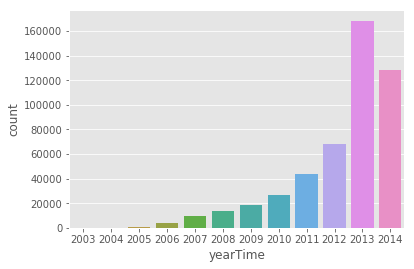

In [112]:
# Show number of reviews of healthy products for 'Grocery & Gourmet Food' over time
sb.countplot(x='yearTime', data=merged_food_healthy_df)

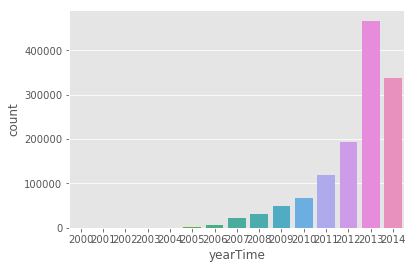

In [113]:
# Show number of reviews for 'Grocery & Gourmet Food' over time
sb.countplot(x='yearTime', data=reviews_food_df)

Another file that seems interesting for finding healthy products is the 'Sports & Outdoors' one. As we can see, this one contains categories that seem easy to categorize into healthy (or not), e.g. 'Exercise & Fitness' or 'Cycling', plus the products seem to be in more precise categories (not like in the 'Grocery & Gourmet Food' file). Thus, in order to get all reviews about products related to an healthy lifestyle, we could take all the reviews about a product that is in one of the 'healthy' categories, and we can choose those healthy categories manually.

In [114]:
# Metadata about healthy sport items only
meta_sport_healthy_df = meta_sport_df[meta_sport_df.apply(lambda item: is_sport_item_healthy(item), axis=1)]
print(meta_sport_healthy_df.shape)
meta_sport_healthy_df.head()

(113412, 9)


,asin,title,price,imUrl,related,brand,categories,salesRank,description
17,0736060332,Power Systems Advanced Strength Training,36.18,http://ecx.images-amazon.com/images/I/51-ZZHhF...,NaN,Power Systems,"[[Sports & Outdoors, Exercise & Fitness]]",{'Sports &amp; Outdoors': 1288415},New! Maximize strength gains with scientifical...
24,0743609972,Maptech ChartKit&reg; Book w/ Companion CD: Re...,120.00,http://ecx.images-amazon.com/images/I/31kGOYj1...,"{'also_bought': ['1883465206', '074360962X', '...",Maptech,"[[Sports & Outdoors, Cycling, Bike Racks & Bag...",{'Sports &amp; Outdoors': 117831},CHARTKIT Bookw/ Companion CDNew York to Nantuc...
29,0930559029,Karate - Uechi-ryu Basic 4 dvd Course,58.00,http://ecx.images-amazon.com/images/I/41BmpYom...,"{'also_viewed': ['1495324508', 'B00C75VSZW', '...",NaN,"[[Sports & Outdoors, Exercise & Fitness, Exerc...",{'Sports &amp; Outdoors': 372679},"Traditional Uechi-ryu Karate basic program, ta..."
32,0963993208,Yoga With Richard Freeman: Ashtanga Yoga: The...,NaN,http://ecx.images-amazon.com/images/I/4102JQ6E...,"{'also_viewed': ['B000NIVNKK', 'B001XRTS9S', '...",NaN,"[[Movies & TV, TV], [Sports & Outdoors, Exerci...",{'Movies & TV': 476594},"Based on the Ashtanga practice,Yoga with Richa..."
33,0965042138,Combat Conditioning: Functional Exercises for ...,317.12,http://ecx.images-amazon.com/images/I/516WZgV5...,"{'also_viewed': ['B001VAA5TO', '0345528581', '...",Title Boxing,"[[Sports & Outdoors, Exercise & Fitness]]",{'Sports &amp; Outdoors': 411093},Learn a myriad of exercises to take you to the...


In [115]:
# Reviews about healthy sport items merged with corresponding metadata
merged_sport_healthy_df = pd.merge(meta_sport_healthy_df[METADATA_TO_KEEP], reviews_sport_df[REVIEWS_DATA_TO_KEEP], on='asin')
print(merged_sport_healthy_df.shape)
merged_sport_healthy_df.head()

(892292, 8)


,asin,title,categories,price,overall,reviewText,yearMonthTime,yearTime
0,0736060332,Power Systems Advanced Strength Training,"[[Sports & Outdoors, Exercise & Fitness]]",36.18,5.0,A great dvd on bodybuilding showing you how to...,2014-04,2014
1,0743609972,Maptech ChartKit&reg; Book w/ Companion CD: Re...,"[[Sports & Outdoors, Cycling, Bike Racks & Bag...",120.00,5.0,smth that every boater must have. easy to navi...,2013-08,2013
2,0930559029,Karate - Uechi-ryu Basic 4 dvd Course,"[[Sports & Outdoors, Exercise & Fitness, Exerc...",58.00,5.0,Exceeded my expectations with a good product a...,2013-03,2013
3,0963993208,Yoga With Richard Freeman: Ashtanga Yoga: The...,"[[Movies & TV, TV], [Sports & Outdoors, Exerci...",NaN,2.0,Thankfully I checked this video out from my lo...,2002-09,2002
4,0963993208,Yoga With Richard Freeman: Ashtanga Yoga: The...,"[[Movies & TV, TV], [Sports & Outdoors, Exerci...",NaN,1.0,"I am a beginner, I admit, but I bought this vi...",2003-11,2003


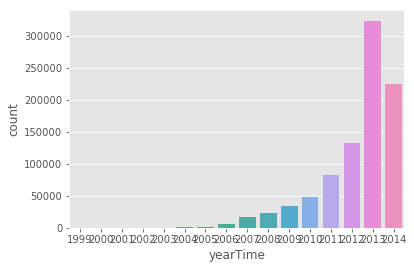

In [116]:
# Show number of reviews of healthy products for 'Sports & Outdoors' over time
sb.countplot(x='yearTime', data=merged_sport_healthy_df)

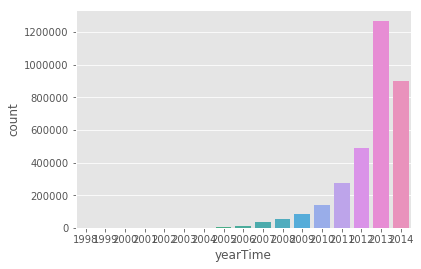

In [117]:
# Show number of reviews for 'Sports & Outdoors' over time
sb.countplot(x='yearTime', data=reviews_sport_df)

Now that we have reviews of healthy products from both files, we can concatenate them and use those as our healthy reviews.

In [118]:
# All reviews about any healthy products with corresponding metadata
merged_healthy_df = pd.concat([merged_food_healthy_df, merged_sport_healthy_df])
print(merged_healthy_df.shape)
merged_healthy_df.head()

(1373958, 8)


,asin,title,categories,price,overall,reviewText,yearMonthTime,yearTime
0,0657745316,100 Percent All Natural Vanilla Extract,[[Grocery & Gourmet Food]],NaN,5.0,"No sugar, no GMO garbage, no fillers that come...",2013-10,2013
1,141278509X,Archer Farms Strawberry Dragonfruit Drink Mix ...,[[Grocery & Gourmet Food]],NaN,5.0,This product by Archer Farms is the best drink...,2012-03,2012
2,1453060375,Mio Energy Liquid Water Enhancer Black Cherry ...,[[Grocery & Gourmet Food]],11.99,1.0,Don't buy this item - rip off at this price. ...,2013-03,2013
3,3295000018,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",[[Grocery & Gourmet Food]],14.80,4.0,I use like a 1/3 of a teaspoon in a spicy cup ...,2014-05,2014
4,3295000018,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",[[Grocery & Gourmet Food]],14.80,5.0,"I've enjoyed many varieties of hot sauces, but...",2014-06,2014
